# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке.

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета
- **Fare**: стоимость проезда пассажира
- **Cabin**: номер каюты
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

Установите количество пропущенных значений поля <code>age</code>:

In [2]:
df = pd.read_csv('https://courses.openedu.ru/assets/courseware/v1/8baa546c1c38f02f9ef2c11333112e89/asset-v1:ITMOUniversity+MLDATAN+spring_2024_ITMO_bac+type@asset+block/titanic_train.csv')

In [3]:
df.age.isna().sum()

199




---


> **199** NaN в age



---



Определите долю выживших

In [4]:
df.survived.value_counts(normalize=True)[1]

0.382262996941896




---


> **0.382** доля выживших



---



Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [5]:
df.isna().sum()

pclass         0
survived       0
name           0
sex            0
age          199
sibsp          0
parch          0
ticket         0
fare           0
cabin        769
embarked       0
home.dest    414
dtype: int64

In [6]:
len(df) / 3

327.0

In [7]:
df = df.drop(columns=['cabin', 'home.dest', 'ticket'])

Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>.

In [8]:
df['fam_size'] = df.sibsp + df.parch

df = df.drop(columns=['sibsp', 'parch'])

In [9]:
df.fam_size.mean()

0.8664627930682977




---


> **0.866** выборочное среднее колонки fam_size



---



Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [10]:
df1 = df

df

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0




> **7** предикторов (без классовой переменной survived)



На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [11]:
df[(df.sex == 'female') & (df.pclass == 1)].survived.value_counts(normalize=True)[1]

0.9711538461538461



> **0.971** вероятность выжить, если пассажир женщина 1 класса


Постройте гистограммы выжиших и невыживших по возрастам.

Text(0.5, 1.0, 'Выжившие')

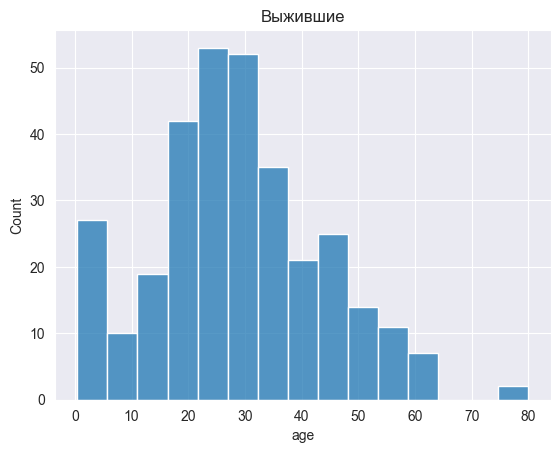

In [12]:
sns.histplot(df[df['survived'] == 1], x = 'age')
plt.title('Выжившие')

Text(0.5, 1.0, 'Не выжившие')

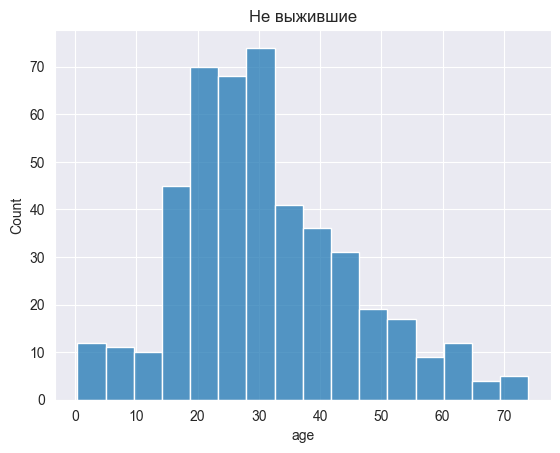

In [13]:
sns.histplot(df[df['survived'] == 0], x = 'age')
plt.title('Не выжившие')

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [14]:
df = df1

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    981 non-null    int64  
 1   survived  981 non-null    int64  
 2   name      981 non-null    object 
 3   sex       981 non-null    object 
 4   age       782 non-null    float64
 5   fare      981 non-null    float64
 6   embarked  981 non-null    object 
 7   fam_size  981 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 61.4+ KB


In [15]:
df_cat = ['name', 'sex', 'embarked']

In [16]:
df = df.drop(columns=df_cat)

In [17]:
df2 = df

df = df.dropna()

In [18]:
from sklearn.model_selection import train_test_split

X = df.drop('survived', axis=1)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=y)

In [19]:
lr = LogisticRegression(random_state=33, max_iter=1000).fit(X_train, y_train)

In [20]:
prediction = lr.predict(X_test)

f1_score(y_test, prediction)

0.5391304347826087

## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [21]:
df = df2

In [22]:
from sklearn.impute import SimpleImputer

mis_replacer = SimpleImputer(strategy='mean')

df = pd.DataFrame(mis_replacer.fit_transform(df), columns=df.columns)

In [23]:
X = df.drop('survived', axis=1)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=y)

In [24]:
lr = LogisticRegression(random_state=33, max_iter=1000).fit(X_train, y_train)

In [25]:
prediction = lr.predict(X_test)

f1_score(y_test, prediction)

0.49557522123893805

## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку.

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [26]:
df = df1

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    981 non-null    int64  
 1   survived  981 non-null    int64  
 2   name      981 non-null    object 
 3   sex       981 non-null    object 
 4   age       782 non-null    float64
 5   fare      981 non-null    float64
 6   embarked  981 non-null    object 
 7   fam_size  981 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 61.4+ KB


In [28]:
df_cat = ['name', 'sex', 'embarked']

In [29]:
df = df.drop(columns=df_cat)

In [30]:
df

,pclass,survived,age,fare,fam_size
0,3,1,NaN,7.7333,0
1,3,1,NaN,7.7500,0
2,3,1,38.0,7.2292,0
3,3,0,22.0,7.8958,0
4,3,0,16.0,9.5000,0
...,...,...,...,...,...
976,3,1,NaN,8.0500,0
977,3,1,19.0,8.0500,0
978,2,0,34.0,13.0000,0
979,3,0,22.0,8.0500,0


In [31]:
honorific = []

for name in df1.name:
  honor = name.split(', ')[1].split('.')[0]
  honorific.append(honor)

In [32]:
df['honorific'] = honorific

In [33]:
len(df.honorific.unique())

14

In [34]:
df.honorific.unique()

array(['Miss', 'Mrs', 'Mr', 'Master', 'Mlle', 'Rev', 'Ms', 'Col', 'Dona',
       'Dr', 'the Countess', 'Major', 'Don', 'Capt'], dtype=object)

Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [35]:
df['honorific'] = df['honorific'].replace(['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'], 'Mr')
df['honorific'] = df['honorific'].replace(['Dona', 'the Countess'], 'Mrs')
df['honorific'] = df['honorific'].replace(['Mlle', 'Ms'], 'Miss')

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [36]:
len(df[df['honorific'] == 'Master']) / len(df1[df1['sex'] == 'male'])

0.07232704402515723

Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [37]:
df[df.honorific == 'Master'].age.mean()

5.128205128205129

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [38]:
mean_age_by_honor = df.groupby('honorific')['age'].mean()
mean_age_by_honor

honorific
Master     5.128205
Miss      22.005765
Mr        32.900438
Mrs       36.984252
Name: age, dtype: float64

In [39]:
null_Master_id = df[(df['age'].isnull()) & (df['honorific'] == 'Master')].index
null_Miss_id = df[(df['age'].isnull()) & (df['honorific'] == 'Miss')].index
null_Mr_id = df[(df['age'].isnull()) & (df['honorific'] == 'Mr')].index
null_Mrs_id = df[(df['age'].isnull()) & (df['honorific'] == 'Mrs')].index

In [40]:
df.loc[null_Master_id, 'age'] = mean_age_by_honor[0]
df.loc[null_Miss_id, 'age'] = mean_age_by_honor[1]
df.loc[null_Mr_id, 'age'] = mean_age_by_honor[2]
df.loc[null_Mrs_id, 'age'] = mean_age_by_honor[3]

/var/folders/c2/2hwxbv6j5sd97nrqd5q9vwlw0000gn/T/ipykernel_3390/3869134065.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.loc[null_Master_id, 'age'] = mean_age_by_honor[0]
/var/folders/c2/2hwxbv6j5sd97nrqd5q9vwlw0000gn/T/ipykernel_3390/3869134065.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.loc[null_Miss_id, 'age'] = mean_age_by_honor[1]
/var/folders/c2/2hwxbv6j5sd97nrqd5q9vwlw0000gn/T/ipykernel_3390/3869134065.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     981 non-null    int64  
 1   survived   981 non-null    int64  
 2   age        981 non-null    float64
 3   fare       981 non-null    float64
 4   fam_size   981 non-null    int64  
 5   honorific  981 non-null    object 
dtypes: float64(2), int64(3), object(1)
memory usage: 46.1+ KB


In [42]:
X = df.drop(['survived', 'honorific'], axis=1)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=y)

In [43]:
lr = LogisticRegression(random_state=33, max_iter=1000).fit(X_train, y_train)

In [44]:
prediction = lr.predict(X_test)

f1_score(y_test, prediction)

0.5128205128205128

# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [45]:
df1.age = df.age

In [46]:
df = df1

In [47]:
df = df.drop(['name'], axis=1)

In [48]:
dummies = pd.get_dummies(df[['sex', 'embarked']], drop_first=True)

df = df.drop(['sex', 'embarked'], axis=1)

df[dummies.columns] = dummies

In [49]:
X = df.drop(['survived'], axis=1)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=y)

In [50]:
lr = LogisticRegression(random_state=33, max_iter=1000).fit(X_train, y_train)

In [51]:
prediction = lr.predict(X_test)

f1_score(y_test, prediction)

0.6666666666666666